## Overview

There are two most obvious network architectures to approach this competition: U-net and SSD. Each of them has pros and cons. In particular, U-net provides a relatively simple way to solve the competition challenge using image segmentation. However, this competition requires prediction of an individual mask for each ship rather than one mask for entire image. Therefore, some creative postprocessing may be needed, especially to separate ships with overlapping masks, if it is even possible. Another drawback is that the data is labeled with using pixelized bounding boxes rather than real ship masks, therefore the score of U-net based models is lowered. Meanwhile, implementation of SSD requires usage of rotating bounding boxes (https://arxiv.org/pdf/1711.09405.pdf) that is not common and, therefore, would take additional efforts for development of the model and the corresponding loss function. In addition, bounding boxes are not provided in this competition and must be generated based on the pixel masks. Nevertheless, this approach is expected to provide higher score than U-net, especially since the data is labeled based on pixelized bounding boxes (I expect organizers used SSD with rotating bounding boxes to label train and test data).
Since the first approach is more straightforward, I'll begin with presenting a kernel about U-net. In this post I will describe how to use pretrained ResNet34 to build a high accuracy image segmentation model. In particular, after training only a decoder for 1 epoch (15 min) on 256x256 rescaled images, the dice coefficient reaches ~0.8 (IoU ~0.67) that significantly outperforms all publicly available models posted so far in this competition. After training the entire model for 6 additional epochs with learning rate annealing, the dice coefficient reaches ~0.86 (IoU ~0.75). Due to the kernel run time limit, the model is further trained only for two epochs on 384x384 (dice ~0.87) followed by one epoch on 768x768 images. In an independent run I trained a model on 384x384 images for 12 epochs that boosted dice to 0.89 followed by training on full resolution images that increased dice further to 0.905.

In [1]:
#import os
###################### GPU ################################
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
###########################################################
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

/home/yuan/py36env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Data

In [2]:
PATH = './'
TRAIN = '/mnt/DataStorage/ASDC/train/'
TEST = '/mnt/DataStorage/ASDC/test/'
SEGMENTATION = '/mnt/DataStorage/ASDC/train_ship_segmentations.csv'
PRETRAINED = 'models/Resnet34_lable_256_1.h5'
#PRETRAINED = 'models/Unet34_256_0.h5'
#exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
#                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
#                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
#                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

In [3]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture

In [4]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
#for el in exclude_list:
#    if(el in train_names): train_names.remove(el)
#    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')

One of the challenges of this competition is strong data unbalance. Even if only images with ships are considered, the ratio of mask pixels to the total number of pixels is ~1:1000. If images with no ships are included, this ratio goes to ~1:10000, which is quite tough to handle. Therefore, I drop all images without ships, that makes the training set more balanced and also reduces the time per each epoch almost by 4 times. In an independent run, when the dice of my model reached 0.895, I ran it on images without ships and identified ~3600 false positive predictions out ~70k images. The incorrectly predicted images were incorporated to the training set as negative examples, and training was continued. The problem of false positive predictions can be further mitigated by stacking U-net model with a classification model predicting if ships are present in a particular image (https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection - ~98% accuracy). 
I also noticed that in some kernels the dataset is tried to be balanced by keeping approximately the same number of images with 0, 1, 2, etc. ships. However, this strategy would be effective for such task as ship counting rather than training U-net or SSD.  One possible way to balance the dataset is creative cropping the images that keeps approximately the same number of pixels corresponding to a ship or something else. However, I doubt that such approach will effective in this competition. Therefore, a special loss function must be used to mitigate the data unbalance.

In [5]:
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)
val_n = cut_empty(val_n)

In [6]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [7]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0

The carrently availible on kaggle version of fastai has a bug in RandomLighting data agmentation class. It would be nice if kaggle updated fastai version to the last one, where this and other bugs are fixed.

In [8]:
class RandomLighting(Transform):
    def __init__(self, b, c, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.b,self.c = b,c

    def set_state(self):
        self.store.b_rand = rand0(self.b)
        self.store.c_rand = rand0(self.c)

    def do_transform(self, x, is_y):
        if is_y and self.tfm_y != TfmType.PIXEL: return x  #add this line to fix the bug
        b = self.store.b_rand
        c = self.store.c_rand
        c = -1/(c-1) if c<0 else c+1
        x = lighting(x, b, c)
        return x

In [9]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.CLASS),
                RandomDihedral(tfm_y=TfmType.CLASS),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, 
                aug_tfms=aug_tfms)
    tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #md.is_multi = False
    return md

### Model

The model used in this kernel is inspired by a Carvana example from FastAI course (http://course.fast.ai/index.html). It is composed of a ResNet34 based encoder and a simple upsampling decoder. Similar to the original U-net, skip connections are added between encoder and decoder to facilitate the information flow at different detalization levels. Meanwhile, using a pretrained ResNet34 model allows us to have a powerful encoder capable of handling elaborated feature, in comparison with the original U-net, without a risk of overfitting and necessity of training a big model from scratch. The total capacity of the model is ~21M parameters. Before using, the original ResNet34 model was further fine-tuned on ship/no-ship classification task (https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection).

In [10]:
cut,lr_cut = model_meta[arch]

In [11]:
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

def load_pretrained(model, path): #load a model pretrained on ship/no-ship classification
    weights = torch.load(PRETRAINED, map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)
            
    return model

In [12]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

### Loss function

Loss function is one of the most crucial parts of the completion. Due to strong data unbalance, simple loss functions, such as Binary Cross-Entropy loss, do not really work. Soft dice loss can be helpful since it boosts prediction of correct masks, but it leads to unstable training. Winners of image segmentation challenges typically combine BCE loss with dice (http://blog.kaggle.com/2017/12/22/carvana-image-masking-first-place-interview/). Similar loss function is used in publicly available models in this completion. I would agree that this combined loss function works perfectly for Carvana completion, where the number of pixels in the mask is about half of the total number of pixels. However, 1:1000 pixel unbalance deteriorates training with BCE. 
If one tries to recall what is the loss function that should be used for strongly unbalanced data set, it is focal loss (https://arxiv.org/pdf/1708.02002.pdf), which revolutionized one stage object localization method in 2017. This loss function demonstrates amazing results on datasets with unbalance level 1:10-1000. In addition to focal loss, I include -log(soft dice loss). Log is important in the convex of the current competition since it boosts the loss for the cases when objects are not detected correctly and dice is close to zero. It allows to avoid false negative predictions or completely incorrect masks for images with one ship (the major part of the training set). Also, since the loss for such objects is very high, the model more effectively incorporates the knowledge about such objects and handles them even in images with multiple ships. To bring two losses to similar scale, focal loss is multiplied by 10. The implementation of focal loss is borrowed from https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c .

In [13]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [15]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [16]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

### Training

In [17]:
m_base = load_pretrained(get_base(),PRETRAINED)
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [18]:
models.model

Unet34(
  (rn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [19]:
sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)

In [20]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]
wd=1e-7

In [21]:
learn.freeze_to(1)

Training only the decoder part for 1 epoch (15 min) leads to ~0.8 dice that outperforms all publicly available models in this competition.

In [22]:
learn.fit(1e-2,1,wds=wd,cycle_len=1,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.338032   0.329065   0.997822   0.791061   0.655744  



[array([0.32906]), 0.9978215980918247, 0.7910605467620062, 0.6557437306499648]

In [23]:
learn.save('Unet34_256_0')

Unfreeze the model and train it with differential learning rate. The lr of the head part is still 1e-3, while the middle layers of the model are trained with 1e-4 lr, and the base is trained with even smaller lr, 1e-5, since low level detectors do not vary much from one image data set to another.

In [24]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze() #unfreeze the encoder
learn.bn_freeze(True)

In [25]:
learn.fit(lr,2,wds=wd,cycle_len=1,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.308729   0.287668   0.998118   0.812268   0.685336  
    1      0.287097   0.267207   0.998245   0.823959   0.701814  



[array([0.26721]), 0.9982454878735202, 0.8239588979691026, 0.7018138723826656]

In [26]:
learn.fit(lr/2,2,wds=wd,cycle_len=2,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.287292   0.272611   0.998206   0.823273   0.700976  
    1      0.247616   0.236332   0.998424   0.843682   0.730695  
    2      0.263367   0.251725   0.99834    0.832781   0.7146    
    3      0.237196   0.228848   0.998472   0.847639   0.736519  



[array([0.22885]), 0.998471728167563, 0.8476387184584058, 0.7365185668493894]

The training has been run with learning rate annealing. Periodic lr increase followed by slow decrease drives the system out of steep minima (when lr is high) towards broader ones (which are explored when lr decreases) that enhances the ability of the model to generalize and reduces overfitting.

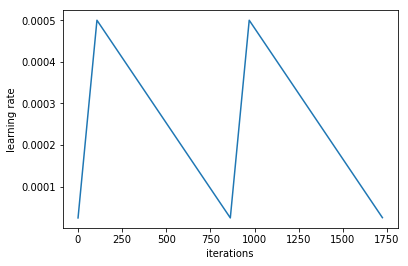

In [27]:
learn.sched.plot_lr()

Saved model can be ued for further training or for making predictions.

In [28]:
learn.save('Unet34_256_1')

### Visualization

In [29]:
def Show_images(x,yp,yt):
    columns = 3
    rows = min(bs,8)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        fig.add_subplot(rows, columns, 3*i+1)
        plt.axis('off')
        plt.imshow(x[i])
        fig.add_subplot(rows, columns, 3*i+2)
        plt.axis('off')
        plt.imshow(yp[i])
        fig.add_subplot(rows, columns, 3*i+3)
        plt.axis('off')
        plt.imshow(yt[i])
    plt.show()

In [30]:
learn.model.eval();
x,y = next(iter(md.val_dl))
yp = to_np(F.sigmoid(learn.model(V(x))))

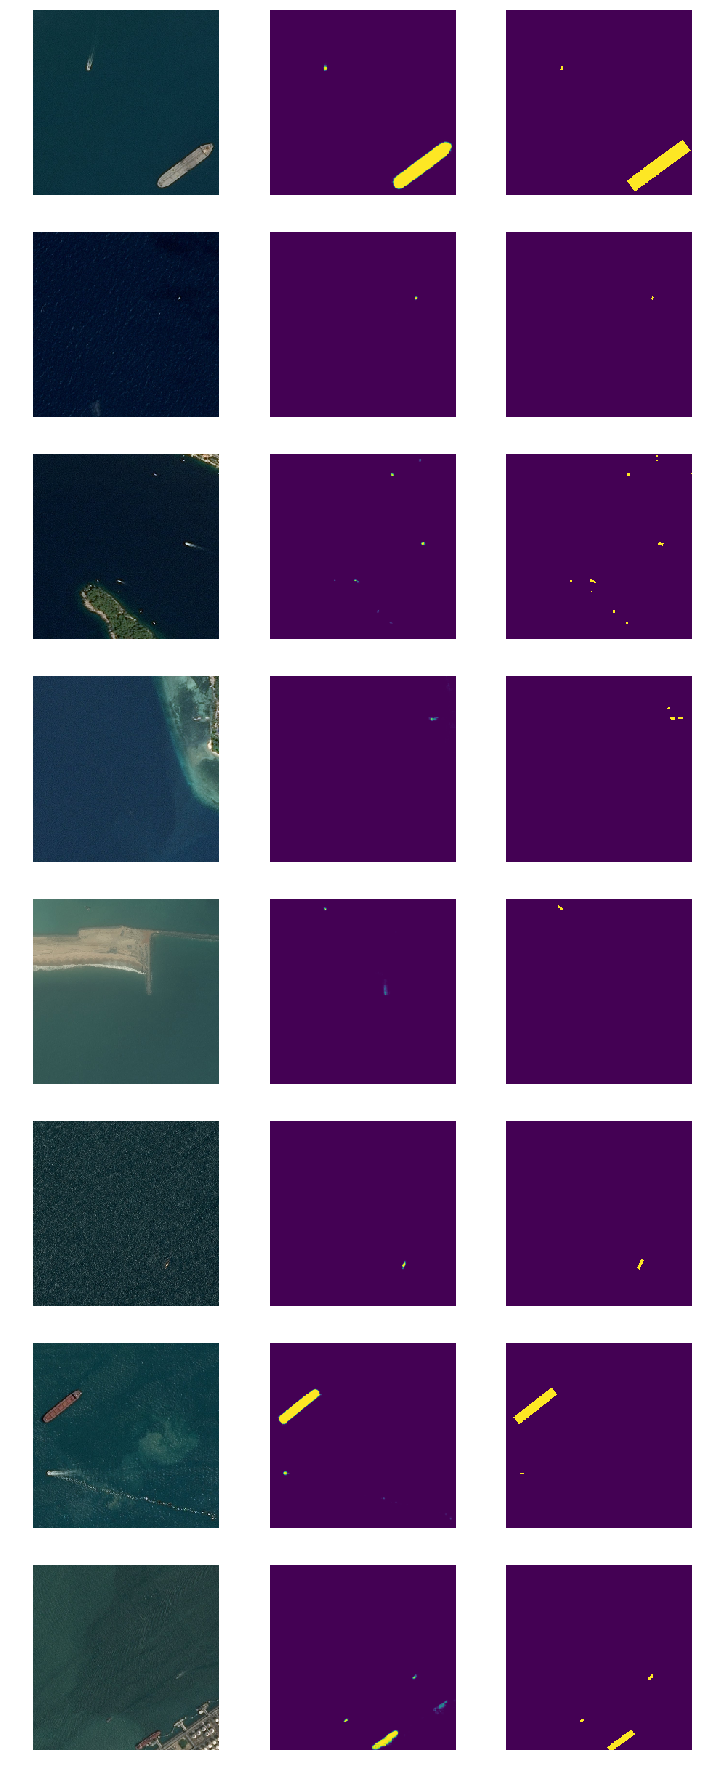

In [31]:
Show_images(np.asarray(md.val_ds.denorm(x)), yp, y)

The results are not ideal, but almost all ships are captured correctly even if the model is making the prediction on a very low resolution (256x256) images.

### Training (384x384)

Fortunately, modern convolutional nets support input images of arbitrary resolution. To decrease the training time, one can start training the model on low resolution images first and continue training on higher resolution images for fewer epochs. In addition, a model pretrained on low resolution images first generalizes better since a pixel information is less available and high order features are tended to be used.

In [32]:
sz = 384 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learn.set_data(md)
learn.unfreeze()
learn.bn_freeze(True)

Due to the kernel run time limit, the model was further trained only for two epochs on 384x384 (dice ~0.87) followed by one epoch on 768x768 images. In an independent run I trained a model on 384x384 images for 12 epochs that boosted dice to 0.89 followed by training on full resolution images that increased dice further to 0.905.

In [33]:
learn.fit(lr/8,6,wds=wd,cycle_len=2,use_clr=(10,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.230207   0.218267   0.998545   0.854826   0.748007  
    1      0.218476   0.2095     0.998595   0.860262   0.756367  
    2      0.210314   0.206263   0.998609   0.861709   0.758228  
    3      0.202174   0.19605    0.998677   0.868406   0.768528  
    4      0.214706   0.198692   0.998662   0.866443   0.765577  
    5      0.20365    0.188217   0.998729   0.873468   0.776366  
    6      0.190893   0.194392   0.998688   0.869207   0.76976   
    7      0.199449   0.183607   0.998759   0.876545   0.781182  
    8      0.204902   0.194147   0.99869    0.86957    0.770434  
    9      0.189645   0.181875   0.998769   0.877399   0.782651  
    10     0.193436   0.182794   0.998762   0.876884   0.781695  
    11     0.183197   0.176913   0.998798   0.880522   0.78748   



[array([0.17691]), 0.9987976156119498, 0.8805217367309381, 0.7874797227611191]

In [34]:
learn.save('Unet34_384_1')

### Visualization

In [35]:
learn.model.eval();
x,y = next(iter(md.val_dl))
yp = to_np(F.sigmoid(learn.model(V(x))))

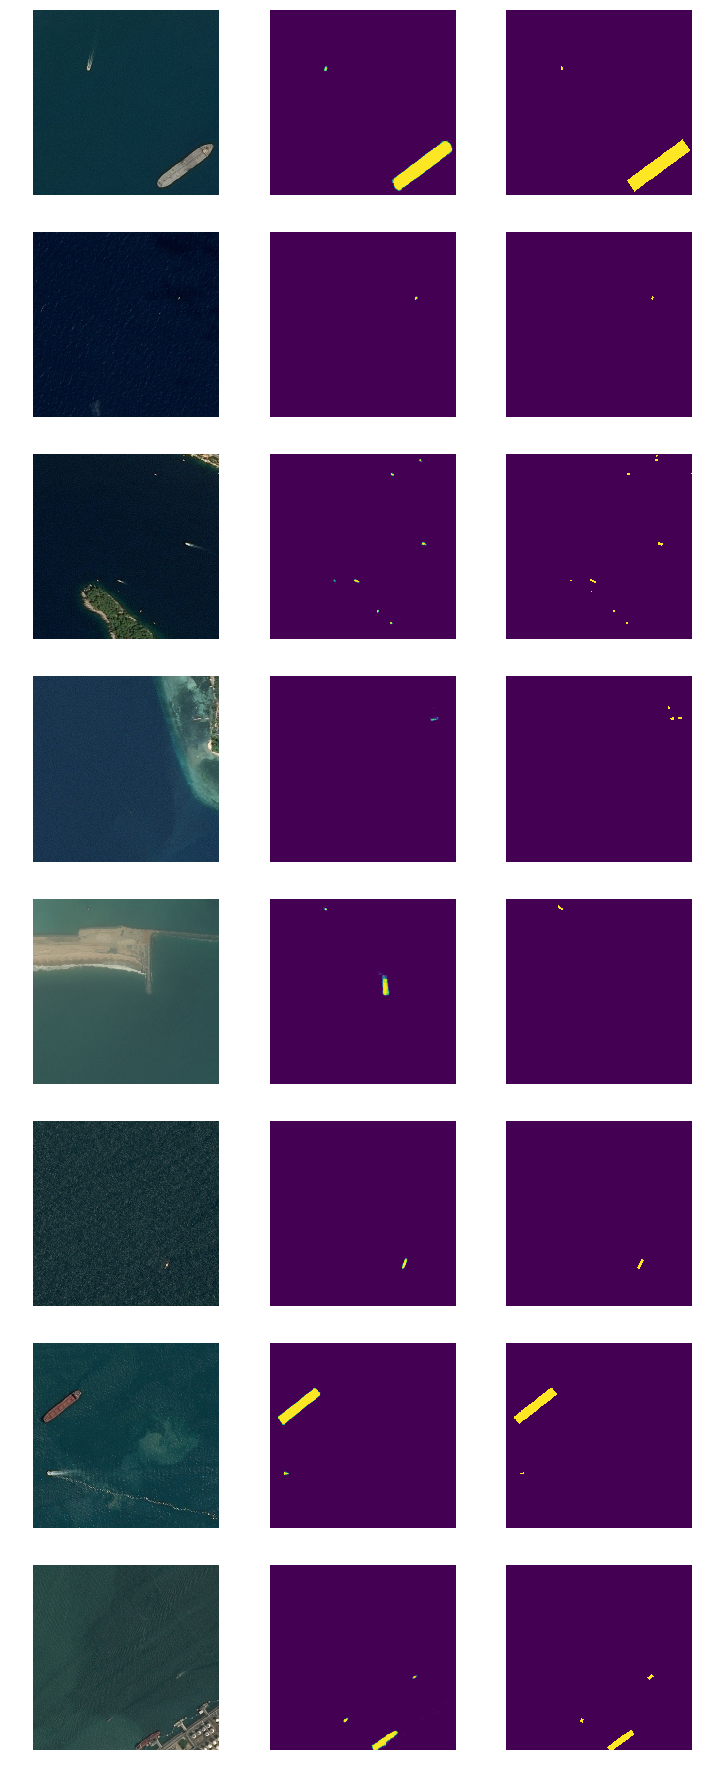

In [36]:
Show_images(np.asarray(md.val_ds.denorm(x)), yp, y)

### Training (768x768)

In [37]:
sz = 768 #image size
bs = 8  #batch size

md = get_data(sz,bs)
learn.set_data(md)
learn.unfreeze()
learn.bn_freeze(True)

In [38]:
learn.fit(lr/20,4,wds=wd,cycle_len=2,use_clr=(10,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.266634   0.243412   0.998494   0.841032   0.733461  
    1      0.228151   0.223444   0.998619   0.85228    0.749213  
    2      0.231959   0.223229   0.998618   0.852843   0.75062   
    3      0.196784   0.208702   0.998701   0.860059   0.760648  
    4      0.207712   0.209032   0.998697   0.860441   0.760818  
    5      0.20463    0.199336   0.998753   0.865491   0.768136  
    6      0.201047   0.203414   0.998747   0.863886   0.766723  
    7      0.204648   0.191245   0.998789   0.870839   0.77605   



[array([0.19125]), 0.9987894833209315, 0.8708393788038874, 0.7760498667891865]

Training for just one epoch is insufficient to achieve high dice. However, if the training is continued, the dice can reach 0.90+.

In [39]:
learn.save('Unet34_768_1')

And finally, I put a picture (original image, prediction, ground truth) obtained by the model with dice 0.895 trained further on full resolution images in an independent run. Apart from one tiny ship in the last image, everything is captured. When I zoomed it in, it is really not clear if it is a ship of just a small island: I see only several white pixels, and there are several small islands under the water. Another interesting thing is that the model is able to capture details that it was not trained for. In particular, in 4-th image the model captures antennas (upper right ship) and the shape of ships, even if training set is composed of pixelized bounding boxes.

![1](https://image.ibb.co/mrqdze/Ship_Detection.png)